### Nonlinear Option Pricing, Master 2 Probabilités et Finance, Sorbonne Université and École polytechnique
# Homework I (optional)

### Due Date: 1:55 PM Tuesday, January 21, 2025
You should turn in the notebook on the Moodle course website.

Please comment your code properly.

Before you turn in the notebook, press the "Run all cells" button in the toolbar, and make sure all the calculation results and graphs are produced correctly in a reasonable time frame, and then save the notebook.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
plt.rc('figure', figsize=(6, 5.5))
plt.rc('axes', grid=True, xmargin=0, ymargin=0, autolimit_mode='round_numbers')

# 1. Conditional Expection and Least Square Regression

Let $X$ and $Y$ be two random variables. The conditional expectation $\mathbb{E}\left[Y|X\right]$ is a function $f^{\ast}$ of $X$ that best approximates $Y$ in the least square sense, i.e.,

$$\mathbb{E}\left[Y|X\right]=f^{\ast}(X)\quad\text{and}\quad\mathbb{E}\left[\left|Y-f^{\ast}(X)\right|^2\right]\leq\mathbb{E}\left[\left|Y-f(X)\right|^2\right]\text{ for any function }f\text{ of }X$$

Let us define the random variables $X$ and $Y$ by
$$
g(x) = x \frac{1 + x}{1 + x^2}, \qquad X \sim \mathcal{N}(0, 1), \quad Y = g(X) + \varepsilon
$$
where $\varepsilon \sim \mathcal{N}(0, 1/16)$ is independent of $X$.

Note that $\mathbb{E}\left[\left.Y\right|X\right] = \mathbb{E}\left[\left.g(X)+\varepsilon\right|X\right] = g(X)+\mathbb{E}\left[\left.\varepsilon\right|X\right] = g(X)$.

Text(0, 0.5, 'Y')

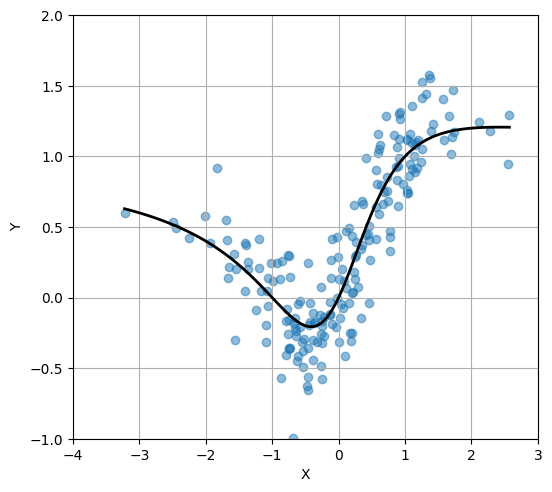

In [2]:
# Plot a random sample of the joint distribution and the 
# theoretical conditional expectation of Y wrt X.

def g(x):
    return x*(1+x)/(1+x**2)

n = 200
sigma = 0.25
X = np.random.randn(n)
Y = g(X) + sigma * np.random.randn(n)

fig, ax = plt.subplots()
ax.scatter(X, Y, alpha=0.5)
x = np.linspace(X.min(), X.max(), 101)
ax.plot(x, g(x), 'k', linewidth=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')

## Parametric regression

The conditional expection $\mathbb{E}\left[\left.Y\right|X\right]$ is approximated by a linear combination of a set of given <em>basis</em> functions $\{f_i(X)\}_{0\leq i\leq n}$, i.e.,

$$\mathbb{E}\left[Y|X\right]\approx \beta_0^*f_0(X)+\cdots+\beta_n^*f_n(X)$$

where 

$$\mathbb{E}\left[\left(Y-\beta_0^*f_0(X)-\cdots-\beta_n^*f_n(X)\right)^2\right] = \min_{\beta_1,\ldots,\beta_n}\mathbb{E}\left[\left(Y-\beta_0f_0(X)-\cdots-\beta_nf_n(X)\right)^2\right]$$

Given $N$ observations $\left((x_1,y_1),\ldots,(x_N, y_N)\right)$ of $X$ and $Y$, one finds the optimal parameters $\beta_i$ by solving the least square problem $\min_\beta\|A\beta-y\|_2$, where

$$A=\begin{bmatrix}f_0(x_1) & \cdots & f_n(x_1)\\ \vdots & \ddots & \vdots \\ f_0(x_N) & \cdots & f_n(x_N)\end{bmatrix}\quad
\text{and}\quad y=\begin{bmatrix}y_1\\ \vdots \\ y_N\end{bmatrix}$$

The numpy routine <strong>numpy.linalg.lstsq</strong> can be used to solve such linear least square problems.

### Polynomials

The basis functions are taken to be power functions $f_i(X)=X^{i}$, that is $\mathbb{E}\left[Y|X\right]$ is a polynomial of $X$. The numpy routine <strong>numpy.polyfit</strong> is a convenient way to obtain the least square polynomial fit.

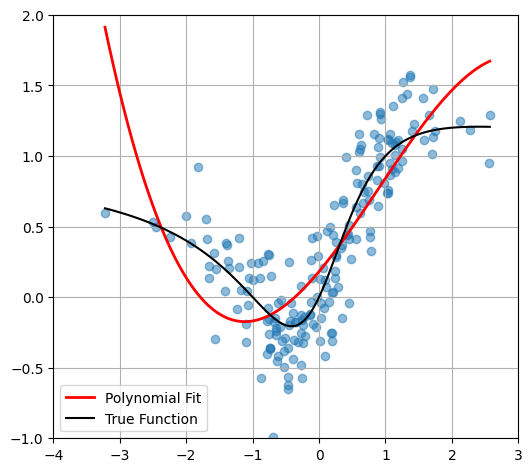

In [4]:
# Fit a polynomial of degree 3 to the sample points (X, Y)
p = np.polyfit(X, Y, deg=3)
fig, ax = plt.subplots()
ax.scatter(X, Y, alpha=0.5)
ax.plot(x, np.polyval(p, x), 'r', lw=2, label='Polynomial Fit')
ax.plot(x, g(x), 'k', label='True Function')
ax.legend(loc=0)

### Piecewise Linear Regression

In [22]:
def pwlin_basis(xknots):
    """Basis that represent a piecewise linear function with given knots"""
    fs = [lambda x: np.ones_like(x, dtype=np.float64), lambda x: x-xknots[0]]
    fs.extend([lambda x, a=xknots[i]: np.maximum(x-a, 0) for i in range(len(xknots))])
    return fs

def pwlin_fit(xdata, ydata, xknots):
    """Fit a piecewise linear function with xknots to xdata and ydata"""
    fs = pwlin_basis(xknots)
    A = np.column_stack([f(xdata) for f in fs])
    ps = np.linalg.lstsq(A, ydata, rcond=None)[0]
    return ps, fs

Text(0, 0.5, 'Y')

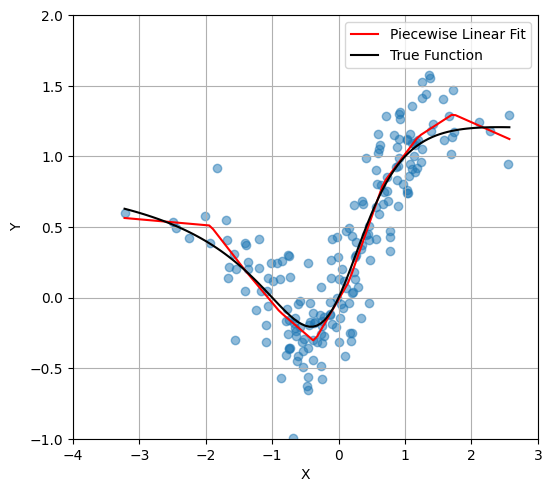

In [23]:
xknots = np.linspace(np.percentile(X, 2.5), np.percentile(X, 97.5), 8)
ps, fs = pwlin_fit(X, Y, xknots)
fig, ax = plt.subplots()
ax.scatter(X, Y, alpha=0.5)
ax.plot(x, sum([f(x)*p for (f, p) in zip(fs, ps)]), 'r', label='Piecewise Linear Fit')
ax.plot(x, g(x), 'k', label='True Function')
ax.legend(loc=0)
ax.set_xlabel('X')
ax.set_ylabel('Y')

## Nonparametric regression

### Nadaraya-Watson Kernel regression (Local Weighted Average)

Here, no parametric form is assumed for $\mathbb{E}[Y|X]$. Instead, local averages of $Y$ values are computed, given the value of $X$:

$$\mathbb{E}\left[Y|X\right]\approx\frac{\sum_{i=1}^NK_h(x-x_i)y_i}{\sum_{i=1}^NK_h(x-x_i)}$$
where $K$ is a kernel function and $K_h(x)=K(x/h)/h$, $h$ is the <em>bandwidth</em>. $K_h$ approximates the Dirac mass at zero.

### Local Linear Regression

The locally weighted linear regression solves a separate weighted least squares problem at each target point $x$,

$$\hat{\alpha},\hat{\beta} = \text{argmin}_{\alpha,\beta}\sum_{i=1}^NK_h(x-x_i)\left[y_i-\alpha-\beta x_i\right]^2$$

which yields an estimate $\hat{\alpha}+\hat{\beta}x$. Note that $\hat{\alpha}$ and $\hat{\beta}$ depend on $x$. The locally-weighted averages can be badly biased on the boundaries. This bias
can be removed by local linear regression to the first order.

<b>Note.</b> To speed up, we often perform the local regression only at a selection of points and then use interpolation/extrapolation to evaluate at other target points.

In [7]:
# Non-parametric regression function

def gauss_kern(x):
    """Gaussian kernel function"""
    return np.exp(-x**2/2)

def kern_reg(x, xdata, ydata, bandwidth, kern=gauss_kern):
    """Nadaraya-Watson Kernel Regression (Locally weighted average)

    Parameters
    ----------
    x: array_like, one-dimensional
        The x-coordinates of the target points
    xdata: array_like
        The x-coordinates of the data points.
    ydata: array_like
        The y-coordinates of the data points. 
    bandwidth: positive scalar
        Bandwidth of the kernel
    kern: callable
        kernel function
    """
    weights = kern((xdata[:, np.newaxis] - x) / bandwidth)
    return np.sum(weights * ydata[:, np.newaxis], axis=0) / np.sum(weights, axis=0)


def ll_reg(x, xdata, ydata, bandwidth, kern=gauss_kern):
    """Local Linear Regression

    Parameters
    ----------
    x: array_like, one-dimensional
        The x-coordinates of the target points
    xdata: array_like
        The x-coordinates of the data points.
    ydata: array_like
        The y-coordinates of the data points. 
    bandwidth: positive scalar
        Bandwidth of the kernel
    kern: callable
        kernel function
    """
    
    def func(xx):
        weights = np.sqrt(kern((xdata-xx)/bandwidth))
        b = ydata*weights
        A = np.column_stack((np.ones_like(xdata), xdata-xx))*weights[:, np.newaxis]
        yy, _ = np.linalg.lstsq(A, b, rcond=None)[0]
        return yy
    
    return np.vectorize(func)(x)

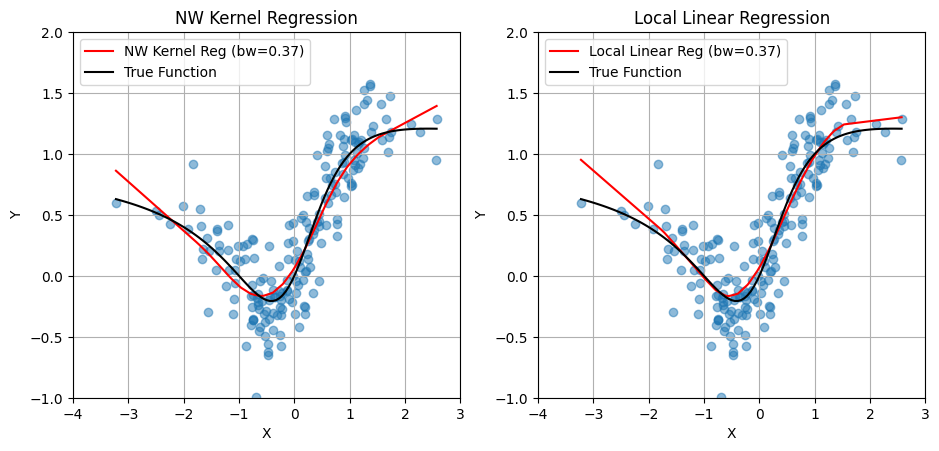

In [8]:
fig, axs = plt.subplots(1,2, figsize=(11, 4.75))
bw_silverman = (4/(3*len(X)))**0.2*np.std(X)
# NW Kernel Regression
xknots0 = np.linspace(np.percentile(X, 2.5), np.percentile(X, 97.5), 20)
yknots0 = kern_reg(xknots0, X, Y, bw_silverman, gauss_kern)
f0 = interp1d(xknots0, yknots0, kind='linear', fill_value='extrapolate')
axs[0].plot(x, f0(x), color='r', label='NW Kernel Reg (bw={:.2f})'.format(bw_silverman))
axs[0].set_title('NW Kernel Regression')
# Local Linear Regression
xknots1 = xknots0
yknots1 = ll_reg(xknots1, X, Y, bw_silverman, gauss_kern)
f1 = interp1d(xknots1, yknots1, kind='linear', fill_value='extrapolate')
axs[1].plot(x, f1(x), color='r', label='Local Linear Reg (bw={:.2f})'.format(bw_silverman))
axs[1].set_title('Local Linear Regression')
for ax in axs:
    ax.scatter(X, Y, alpha=0.5)
    ax.plot(x, g(x), 'k', label='True Function')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(loc=0)

## Questions

<b>Question 1.1</b>. (Parametric regression) In general, increasing the number of basis functions in the regression gives us more flexibility to better fit the data. However, having too many parameters in the model oftentimes leads to overfitting, which usually has poor predictive performance and is over-sensitive to small noise in the data. To observe the overftting phenomenon, in polynomial fit, try to use different degrees of the polynomials; in piecewise-linear regression, try to use difference number of knots. Then reproduce the scatter plot with fitted regression function. Compare and comment on the results.

# Question 1.2: Nonparametric Regression

## Instructions:
1. Essayez différentes valeurs de bande passante dans la régression par noyau.
2. Reproduisez le diagramme de dispersion avec la fonction de régression ajustée.
3. Comparez et commentez les résultats :
   - Pour quelles valeurs de bande passante observe-t-on un surapprentissage (overfitting) ?
   - Pour quelles valeurs de bande passante observe-t-on un ajustement médiocre (poor fit) ?
4. Essayez d'utiliser différents noyaux, par exemple :

   $
   K(x) = (x+1)^2(1-x)^2 \quad \text{pour } -1 \leq x \leq 1 \quad \text{et} \quad 0 \quad \text{ailleurs.}
   $

   Quelle est l'impact le plus important : la bande passante \(h\) ou le noyau \(K\) ?


# 2. American Option Pricing

In [30]:
def blackscholes_mc(ts, n_paths, S0, vol, r, q):
    """Generate Monte-Carlo paths in Black-Scholes model.

    Parameters
    ----------
    ts: array_like
        The time steps of the simualtion
    n_paths: int
        the number of paths to simulate
    S0: scalar
        The spot price of the underlying security.
    vol: scalar
        The implied Black-Scholes volatility.
    r: scalar
        The annualized risk-free interest rate, continuously compounded.
    q: scalar
        The annualized continuous dividend yield.

    Returns
    -------
    paths: ndarray
        The Monte-Carlo paths.
    """
    paths = np.full((len(ts), n_paths), np.nan, dtype=np.float64)
    paths[0] = S0
    for i in range(len(ts)-1):
        dt = ts[i+1] - ts[i]
        dW = np.sqrt(dt)*np.random.randn(n_paths)
        paths[i+1] = paths[i] * np.exp((r-q-1/2*vol**2)*dt + vol*dW)
    return paths

In [31]:
S0 = 100
vol = 0.2
r = 0.1
q = 0.02
K = 100
T = 1

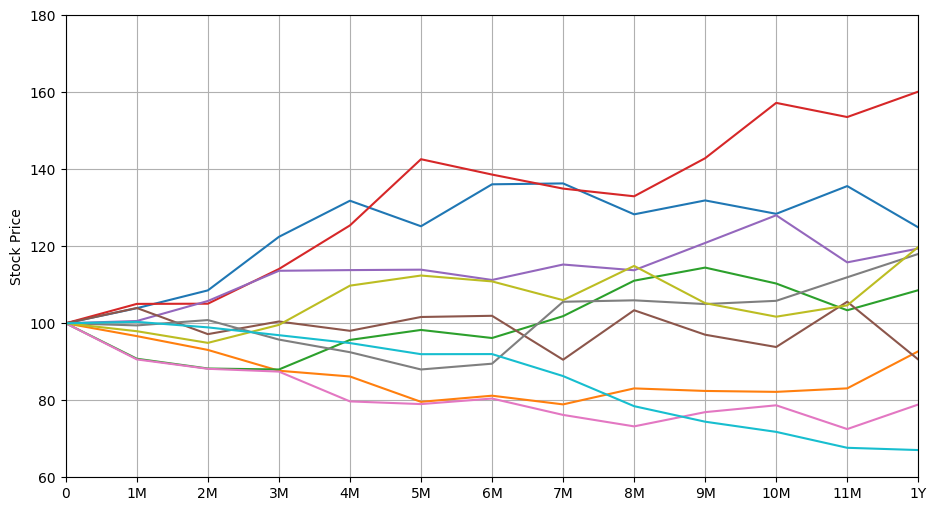

In [32]:
ts = np.linspace(0, 1, 13)
n_paths = 10000
paths = blackscholes_mc(ts, n_paths, S0, vol, r, q)
fig, ax = plt.subplots(figsize=(11, 6))
ax.plot(ts, paths[:, :10])
ax.set_xticks(ts)
ax.set_xticklabels(['0', '1M', '2M', '3M', '4M', '5M', '6M', '7M', '8M', '9M', '10M', '11M', '1Y'])
ax.set_ylabel('Stock Price')
ax.grid(True)

### Price of European put option

In [33]:
np.mean(np.maximum(K-paths[-1], 0))*np.exp(-r*T)

4.305923870551351

### Price of Bermudan put option with monthly exercises

#### Longstaff-Schwartz algorithm

We use polynomials as basis functions for demonstration purposes.

In [34]:
payoff = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount
    p = np.polyfit(paths[i], payoff, deg=2)
    contval = np.polyval(p, paths[i])
    exerval = np.maximum(K-paths[i], 0)
    # identify the paths where we should exercise
    ind = exerval > contval
    payoff[ind] = exerval[ind]
np.mean(payoff*np.exp(-r*(ts[1]-ts[0])))

5.003855805800313

#### Tsitsiklis-van Roy algorithm

The price from the TVR algorithm is generally too high because regression errors accumulate in the backward induction.

In [35]:
V = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    p = np.polyfit(paths[i], V*discount, deg=2)
    contval = np.polyval(p, paths[i])
    exerval = np.maximum(K-paths[i], 0)
    V = np.maximum(exerval, contval)
np.mean(V)*np.exp(-r*(ts[1]-ts[0]))

6.3353027006373885

## Questions

<b>Question 2.1</b>. Adapt the Longstaff-Schwartz and TVR code to use different regression methods:

<b>(a).</b> Black-Scholes put prices.
<br>
Use the constant 1.0 and the Black-Scholes price of a European put option with volatility $\bar\sigma = 0.2$ and maturity $T-t$ as the two basis functions at time $t$. For your convenience, the Black-Scholes pricing formula is included in the cell below.

<b>(b).</b> Piecewise Linear regression.

Note: choose the number of knots appropriately in the regression.</li>

<b>(c).</b> Kernel regression with Gaussian kernel.

Note: Choose the bandwidth appropriately.</li>

In [14]:
def blackscholes_price(K, T, S0, vol, r=0, q=0, callput='call'):
    """Compute the call/put option price in the Black-Scholes model
    
    Parameters
    ----------
    K: scalar or array_like
        The strike of the option.
    T: scalar or array_like
        The maturity of the option, expressed in years (e.g. 0.25 for 3-month and 2 for 2 years)
    S0: scalar or array_like
        The current price of the underlying asset.
    vol: scalar or array_like
        The implied Black-Scholes volatility.
    r: scalar or array_like
        The annualized risk-free interest rate, continuously compounded.
    q: scalar or array_like
        The annualized continuous dividend yield.
    callput: str
        Must be either 'call' or 'put'.

    Returns
    -------
    price: scalar or array_like
        The price of the option.

    Examples
    --------
    >>> blackscholes_price(95, 0.25, 100, 0.2, r=0.05, callput='put')
    1.5342604771222823
    """
    F = S0*np.exp((r-q)*T)
    v = vol*np.sqrt(T)
    d1 = np.log(F/K)/v + 0.5*v
    d2 = d1 - v
    try:
        opttype = {'call':1, 'put':-1}[callput.lower()]
    except:
        raise ValueError('The value of callput must be either "call" or "put".')
    price = opttype*(F*norm.cdf(opttype*d1)-K*norm.cdf(opttype*d2))*np.exp(-r*T)
    return price

<b>Question 2.2</b>. Both TVR and Longstaff-Schwartz algorithms provide an estimate for the expected payoff from continuation at each exercise date from the cross-sectional information in the simulation using regression. By comparing this estimate with the immediate exercise value, the holder of the option can determine whether to exercise the option or continue. 

Perform an independent Monte Carlo simulation using this estimate of continuation value from <b>both</b> algorithms as an exercise policy, and estimate the price of the American put. Explain why this estimate is a lower bound. The basis functions for regression can be chosen to be the quadratic polynomial as in the sample code.

Show your code and result with at least 100000 simulations.

<b>Question 2.3</b> Oftentimes parametric regressions may not produce globally accurate estimates of continuation values for all possible values of state variables. One approach to improve the accuracy is to run regression only in the region where option is in the money. When the option is out of money, one should always choose to continue, therefore there is no need to estimate the continuation value.

Modify the Longstaff-Schwartz code to implement this improvement.

Show your code and results with the following basis functions:

<b>(a).</b> quadratic polynomial basis functions;

<b>(b).</b> basis functions given in Question 2.1(a)

For each case, identify and plot the exercise and continuation regions at time $t=0.5$. Comment on the result.

<b>Question 2.4</b>. Use the Longstaff-Schwartz algorithm to price an Bermudan-Asian call option. The underlying security price is assumed to follow the geometric Brownian motion

$$\frac{dS_t}{S_t}=(r-q)dt+\sigma dW_t$$

with $S_0=100$, $r=0$, $q=0$ and $\sigma=0.2$. The option has a strike of $K=100$ and a final expiration date of $T=1$ and can be exercised every month before the final maturity, i.e.
$$t_1=\frac{1}{12},\, t_2=\frac{2}{12},\, \ldots,\, t_{12}=1$$

The cashflow from exercising the option at time $t_n$, $n=1,\ldots,12$, is $\max\left(0, A_{t_n}-K\right)$ with $A_{t_n}=\frac{1}{n}\sum_{i=1}^nS_{t_i}$.

<b>(a).</b>
As the basis functions in the regression at time $t_n$, use the constant 1.0 and the Black-Scholes value of a European call option with strike $K$, maturity $T-t_n$, volatility $\bar\sigma = 0.1$, and the spot value
$$
Z_{t_n}\equiv \frac{nA_{t_n}+(12-n)S_{t_n}}{12}
$$

As in Question 2.4, after you have obtained estimations of continuation values from the Longstaff-Schwartz algorithm, run an independent Monte Carlo simulation with at least 100000 paths to obtain a low-biased price. Explain the use of $Z_{t_n}$ instead of simply $A_{t_n}$ or $S_{t_n}$.

<b>(b).</b> Implement a feed-forward neural network to estimate the conditional value at each time step. The network should take both $S_{t_n}$ and $A_{t_n}$ as inputs. As in part (a), after all estimations of continuation values are obtained, run an indepedent Monte Carlo simulation to get a low-biased price.

Technical Tips: You should use tensorflow to implement the neural networks. There is a tensorflow example in the test notebook for your reference. For this problem, we recommend the following hyperparameters: 3 hidden layers with 20 neurons and RELU activation on each layer. To control the time of training, we recommend training size of 50000 paths and batch size of 128 in the stochastic gradient descent. You can do the usual training/validation split, and use the validation loss to early-stop the training. 